In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("dep1_cleaned.csv")

In [3]:
data['tweet'] = data['tweet'].astype(str)
data.head()

,Unnamed: 0,tweet,target
0,0,Today in Selfcare: beauty ; laughs Kung Fu Pan...,0
1,1,I get to spend New Year's home again alone and...,1
2,2,"Depressed and lonely /: Stuck in a deep, never...",1
3,3,If this is your response to someone saying the...,0
4,4,Apparently you get a free pass just by mention...,0


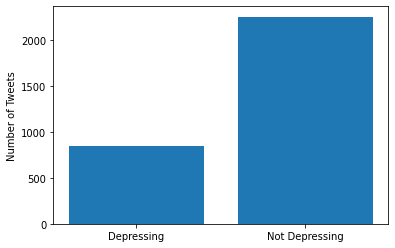

In [4]:
#Visualization
sh=0
for i in range(len(data["target"])):
    if data["target"].iloc[i]==1:
        sh+=1
normal=len(data["target"])-sh
label_values={"Depressing" : sh, "Not Depressing" : normal}
plt.bar(label_values.keys(),label_values.values(),align="center")
plt.ylabel("Number of Tweets")
plt.show()

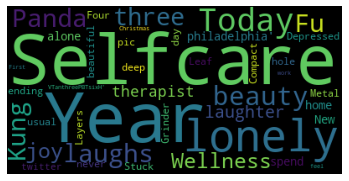

In [7]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

text = data['tweet'].values 

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [8]:
print("No. of Label 1 tweets")
print(len(data[data["target"].isin([1])]))
print("No. of Label 0 tweets")
print(len(data[data["target"].isin([0])]))
print("Class Balance Ratio")
print((len(data[data["target"].isin([1])]))/len(data))

No. of Label 1 tweets
842
No. of Label 0 tweets
2254
Class Balance Ratio
0.2719638242894057


In [9]:
import tensorflow as tf
import sklearn
import seaborn as sbs
import sklearn.naive_bayes 
import sklearn.model_selection
import sklearn.metrics

In [10]:
!pip3 install bert-for-tf2

In [11]:
import tensorflow_hub as hub 
from bert import bert_tokenization
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [12]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

In [13]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [14]:
max_len = 100
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(data.tweet, data['target'], 
                                                                          test_size=0.2, random_state=0)
# print(X_train['Text'])
# X_train['Text'] = X_train['Text'].apply(lambda x : string(x))
X_train = bert_encode(X_train, tokenizer, max_len=max_len)
X_val = bert_encode(X_val, tokenizer, max_len=max_len)

In [15]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [16]:
%%time
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_history = model.fit(
    X_train, y_train, 
   
    epochs=5,
    callbacks=[checkpoint, earlystopping],
    batch_size=1,
    verbose=1
)

Epoch 1/5
2476/2476 [==============================] - 156s 58ms/step - loss: 0.4755 - accuracy: 0.7812


Epoch 2/5
2476/2476 [==============================] - 144s 58ms/step - loss: 0.2445 - accuracy: 0.8994


Epoch 3/5
2476/2476 [==============================] - 144s 58ms/step - loss: 0.0869 - accuracy: 0.9722


Epoch 4/5
2476/2476 [==============================] - 144s 58ms/step - loss: 0.0363 - accuracy: 0.9898


Epoch 5/5
2476/2476 [==============================] - 144s 58ms/step - loss: 0.0222 - accuracy: 0.9948


CPU times: user 8min 29s, sys: 3min 5s, total: 11min 34s
Wall time: 12min 11s


In [17]:
train_history.history

{'accuracy': [0.796445906162262,
  0.8921647667884827,
  0.9660742878913879,
  0.9874798059463501,
  0.9890953302383423],
 'loss': [0.440819650888443,
  0.2507935166358948,
  0.0930287316441536,
  0.0440223403275013,
  0.03218967840075493]}

In [18]:
test_performance=model.evaluate(X_val,y_val)
print((test_performance))
print("The loss of the model on the test set : {}".format(test_performance[0]))
print("The accuracy of the model on the test set : {}%".format(test_performance[1]*100))
y_pred = model.predict(X_val)

20/20 [==============================] - 5s 207ms/step - loss: 0.7957 - accuracy: 0.8452
[0.7956849336624146, 0.8451613187789917]
The loss of the model on the test set : 0.7956849336624146
The accuracy of the model on the test set : 84.51613187789917%


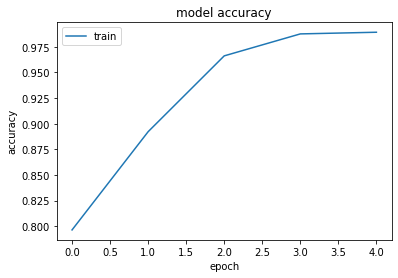

In [19]:
plt.plot(train_history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

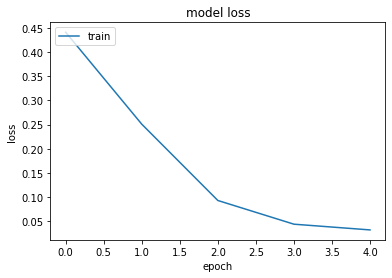

In [20]:
plt.plot(train_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
y_pred = np.round(y_pred)

In [22]:
from sklearn.metrics import f1_score
print(f1_score(y_val, y_pred, average='macro'))
print(f1_score(y_val, y_pred, average='micro'))
print(f1_score(y_val, y_pred, average='weighted'))
print(f1_score(y_val, y_pred, average=None))
print(f1_score(y_val, y_pred, zero_division=1))

0.8047730880751518
0.8451612903225807
0.8443019668705075
[0.89356984 0.71597633]
0.7159763313609467


In [23]:
from sklearn.metrics import recall_score
print(recall_score(y_val, y_pred, average='macro'))
print(recall_score(y_val, y_pred, average='micro'))
print(recall_score(y_val, y_pred, average='weighted'))
print(recall_score(y_val, y_pred, average=None))
print(recall_score(y_val, y_pred, average=None, zero_division=1))

0.8015209717607974
0.8451612903225807
0.8451612903225807
[0.89955357 0.70348837]
[0.89955357 0.70348837]


In [24]:
from sklearn.metrics import precision_score
print(precision_score(y_val, y_pred, average='macro'))
print(precision_score(y_val, y_pred, average='micro'))
print(precision_score(y_val, y_pred, average='weighted'))
print(precision_score(y_val, y_pred, average=None))
print(precision_score(y_val, y_pred, average=None, zero_division=1))

0.808290430444244
0.8451612903225807
0.8436250044943167
[0.8876652  0.72891566]
[0.8876652  0.72891566]


In [43]:
import math

output_dict = {0:"You are not depressed", 1:"You are depressed."}
new_input = [["I don't feel very good today"],["I feel great"],["I don't feel like getting up in the morning"],["People around me are doing so well and I'm doing nothing."],["Can't wait for tomorrow!"], ["I got nothing to look forward to in life."], ["The shop near my house has antidepressants"], ["Depression is something I've seen other people suffer from but not something I've personally experienced"], ["I don't know what hopelessness means"]]

new_val0 = bert_encode(new_input[0], tokenizer, max_len=max_len)
new_val1 = bert_encode(new_input[1], tokenizer, max_len=max_len)
new_val2 = bert_encode(new_input[2], tokenizer, max_len=max_len)
new_val3 = bert_encode(new_input[3], tokenizer, max_len=max_len)
new_val4 = bert_encode(new_input[4], tokenizer, max_len=max_len)
new_val5 = bert_encode(new_input[5], tokenizer, max_len=max_len)
new_val6 = bert_encode(new_input[6], tokenizer, max_len=max_len)
new_val7 = bert_encode(new_input[7], tokenizer, max_len=max_len)
new_val8 = bert_encode(new_input[7], tokenizer, max_len=max_len)


print ('The sentence is "' + new_input[0][0] + '"')
print (output_dict[(int(round(model.predict(new_val0)[0][0])))])
print("\n")
print ('The sentence is "' + new_input[1][0] + '"')
print (output_dict[(int(round(model.predict(new_val1)[0][0])))])
print("\n")
print ('The sentence is "' + new_input[2][0] + '"')
print (output_dict[(int(round(model.predict(new_val2)[0][0])))])
print("\n")
print ('The sentence is "' + new_input[3][0] + '"')
print (output_dict[(int(round(model.predict(new_val3)[0][0])))])
print("\n")
print ('The sentence is "' + new_input[4][0] + '"')
print (output_dict[(int(round(model.predict(new_val4)[0][0])))])
print("\n")
print ('The sentence is "' + new_input[5][0] + '"')
print (output_dict[(int(round(model.predict(new_val5)[0][0])))])
print("\n")
print ('The sentence is "' + new_input[6][0] + '"')
print (output_dict[(int(round(model.predict(new_val6)[0][0])))])
print("\n")
print ('The sentence is "' + new_input[7][0] + '"')
print (output_dict[(int(round(model.predict(new_val7)[0][0])))])
print("\n")
print ('The sentence is "' + new_input[8][0] + '"')
print (output_dict[(int(round(model.predict(new_val8)[0][0])))])
print("\n")
# print ('The sentence is "' + new_input[9][0] + '"')
# print (output_dict[(int(round(model.predict(new_val9)[0][0])))])
# print("\n")

The sentence is "I don't feel very good today"
You are depressed.


The sentence is "I feel great"
You are not depressed


The sentence is "I don't feel like getting up in the morning"
You are depressed.


The sentence is "People around me are doing so well and I'm doing nothing."
You are depressed.


The sentence is "Can't wait for tomorrow!"
You are not depressed


The sentence is "I got nothing to look forward to in life."
You are depressed.


The sentence is "The shop near my house has antidepressants"
You are not depressed


The sentence is "Depression is something I've seen other people suffer from but not something I've personally experienced"
You are depressed.


The sentence is "I don't know what hopelessness means"
You are depressed.




The Classifier is often giving incorrect predictions for sentences having the words "depressed", "depression", "loneliness", "hopelessness1" in it.
